In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from itertools import product

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

---

In [ ]:
train_df = pd.read_csv('/content/new_train.csv')

In [ ]:
X = train_df.drop(columns='Transported')
y = train_df['Transported']

In [ ]:
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

In [ ]:
X = torch.tensor(X.values).float()
y = torch.tensor(y.values).long()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

---

In [ ]:
class TitanicModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(TitanicModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, output_size)

    def forward(self, X):
        out = self.layer1(X)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.layer4(out)
        return out

In [ ]:
input_size = X_train.shape[1]
output_size = 2

In [ ]:
model = TitanicModel(input_size, output_size).to(device)
model

TitanicModel(
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (layer1): Linear(in_features=17, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
batch_size = 4096
best_loss = float('inf')
patience = 10
counter = 0

In [ ]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
loss_log = []
valid_loss_log = []

epoch = 1
while True:
    model.train()
    for batch_X, batch_y in train_loader:
        pred = model(batch_X.to(device))
        loss = criterion(pred, batch_y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_valid)
        val_loss = criterion(val_pred, y_valid)
        val_predictions = torch.argmax(val_pred, dim=1)
        accuracy = (val_predictions == y_valid).sum().item() / y_valid.size(0)

    print(f"Epoch [{epoch}] - Loss: {(loss.item() * 100):.2f} - Val Loss: {(val_loss.item() * 100):.2f} - Test Accuracy: {(accuracy * 100):.2f}")
    loss_log.append(loss.item())
    valid_loss_log.append(val_loss.item())
    epoch += 1

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping - Epoch {epoch}")
            break

Epoch [1] - Loss: 69.31 - Val Loss: 68.99 - Test Accuracy: 49.52
Epoch [2] - Loss: 69.02 - Val Loss: 68.47 - Test Accuracy: 52.07
Epoch [3] - Loss: 68.50 - Val Loss: 67.93 - Test Accuracy: 59.32
Epoch [4] - Loss: 67.90 - Val Loss: 67.36 - Test Accuracy: 67.08
Epoch [5] - Loss: 67.41 - Val Loss: 66.74 - Test Accuracy: 72.45
Epoch [6] - Loss: 66.77 - Val Loss: 66.06 - Test Accuracy: 75.03
Epoch [7] - Loss: 66.04 - Val Loss: 65.31 - Test Accuracy: 75.59
Epoch [8] - Loss: 65.20 - Val Loss: 64.49 - Test Accuracy: 76.18
Epoch [9] - Loss: 64.46 - Val Loss: 63.59 - Test Accuracy: 76.65
Epoch [10] - Loss: 63.43 - Val Loss: 62.62 - Test Accuracy: 76.79
Epoch [11] - Loss: 62.65 - Val Loss: 61.56 - Test Accuracy: 77.13
Epoch [12] - Loss: 61.80 - Val Loss: 60.43 - Test Accuracy: 77.32
Epoch [13] - Loss: 60.26 - Val Loss: 59.21 - Test Accuracy: 77.55
Epoch [14] - Loss: 59.03 - Val Loss: 57.93 - Test Accuracy: 77.83
Epoch [15] - Loss: 58.20 - Val Loss: 56.59 - Test Accuracy: 78.05
Epoch [16] - Loss: 

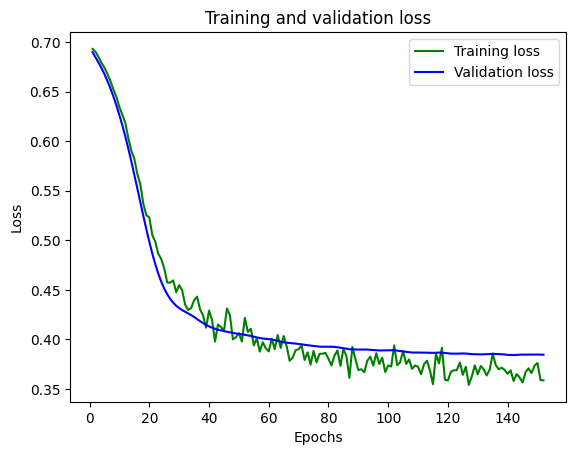

In [ ]:
epochs = range(1, len(loss_log) + 1)  # Create a list of epoch numbers
plt.plot(epochs, loss_log, color='green', label='Training loss')  # Plot using epoch numbers
plt.plot(epochs, valid_loss_log, color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---
**Hyperparams tuning**

In [ ]:
lr_values = [0.001, 0.0005, 0.0001]
wd_values = [0.001, 0.0005, 0.0001]

In [ ]:
def hyperparams_tunning(lr, wd):
    model = TitanicModel(input_size, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    patience = 10
    best_loss = float('inf')
    counter = 0
    epoch = 1

    while True:
        model.train()
        for batch_X, batch_y in train_loader:
            pred = model(batch_X.to(device))
            loss = criterion(pred, batch_y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_valid)
            val_loss = criterion(val_pred, y_valid)
            val_predictions = torch.argmax(val_pred, dim=1)
            accuracy = (val_predictions == y_valid).sum().item() / y_valid.size(0)

        if val_loss < best_loss:
            best_loss = val_loss
            best_accuracy = accuracy
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
        epoch += 1

    return best_accuracy

In [ ]:
best_acc = 0
best_params = None

for lr, wd in product(lr_values, wd_values):
    acc = hyperparams_tunning(lr, wd)
    print(f"LR: {lr}, WD: {wd}, Accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_params = (lr, wd)

print(f"Best params: LR={best_params[0]}, WD={best_params[1]}, Accuracy={best_acc:.4f}")

LR: 0.001, WD: 0.001, Accuracy: 0.8275
LR: 0.001, WD: 0.0005, Accuracy: 0.8259
LR: 0.001, WD: 0.0001, Accuracy: 0.8309
LR: 0.0005, WD: 0.001, Accuracy: 0.8267
LR: 0.0005, WD: 0.0005, Accuracy: 0.8278
LR: 0.0005, WD: 0.0001, Accuracy: 0.8264
LR: 0.0001, WD: 0.001, Accuracy: 0.8270
LR: 0.0001, WD: 0.0005, Accuracy: 0.8270
LR: 0.0001, WD: 0.0001, Accuracy: 0.8267
Best params: LR=0.001, WD=0.0001, Accuracy=0.8309


In [ ]:
best_params

(0.001, 0.0001)

---
**Final model**

In [ ]:
model = TitanicModel(input_size, output_size).to(device)
model

TitanicModel(
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (layer1): Linear(in_features=17, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params[0], weight_decay=best_params[1])

In [ ]:
batch_size = 4096
best_loss = float('inf')
patience = 10
counter = 0

In [ ]:
train_dataset = TensorDataset(X, y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
loss_log = []

epoch = 1
while True:
    model.train()
    for batch_X, batch_y in train_loader:
        pred = model(batch_X.to(device))
        loss = criterion(pred, batch_y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] - Loss: {(loss.item() * 100):.2f}")
    loss_log.append(loss.item())
    epoch += 1

    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping - Epoch {epoch}")
            break

Epoch [1] - Loss: 72.06
Epoch [2] - Loss: 70.47
Epoch [3] - Loss: 69.81
Epoch [4] - Loss: 69.22
Epoch [5] - Loss: 67.96
Epoch [6] - Loss: 66.72
Epoch [7] - Loss: 65.06
Epoch [8] - Loss: 63.87
Epoch [9] - Loss: 62.10
Epoch [10] - Loss: 60.28
Epoch [11] - Loss: 58.64
Epoch [12] - Loss: 56.51
Epoch [13] - Loss: 53.92
Epoch [14] - Loss: 52.28
Epoch [15] - Loss: 50.24
Epoch [16] - Loss: 48.87
Epoch [17] - Loss: 48.46
Epoch [18] - Loss: 48.38
Epoch [19] - Loss: 46.39
Epoch [20] - Loss: 45.02
Epoch [21] - Loss: 46.82
Epoch [22] - Loss: 44.75
Epoch [23] - Loss: 43.49
Epoch [24] - Loss: 45.02
Epoch [25] - Loss: 44.10
Epoch [26] - Loss: 43.02
Epoch [27] - Loss: 42.34
Epoch [28] - Loss: 43.86
Epoch [29] - Loss: 43.32
Epoch [30] - Loss: 42.83
Epoch [31] - Loss: 43.38
Epoch [32] - Loss: 41.86
Epoch [33] - Loss: 40.79
Epoch [34] - Loss: 41.20
Epoch [35] - Loss: 42.40
Epoch [36] - Loss: 42.88
Epoch [37] - Loss: 40.44
Epoch [38] - Loss: 41.96
Epoch [39] - Loss: 43.39
Epoch [40] - Loss: 40.42
Epoch [41

# Predictions

In [ ]:
test_df_original = pd.read_csv('/content/test.csv')
test_df = pd.read_csv('preprocessed_test.csv')
test_df.drop(columns='Transported', inplace=True)

In [ ]:
feature_selection = joblib.load('feature_selection.joblib')
scaler = StandardScaler()

In [ ]:
test_df = test_df[feature_selection]
test_df = scaler.fit_transform(test_df)
test_df = torch.tensor(test_df).float()

In [ ]:
model.eval()
with torch.no_grad():
    test_pred = model(test_df)
    test_predictions = torch.argmax(test_pred, dim=1).numpy()

df_submission = pd.DataFrame({
    'PassengerId': test_df_original['PassengerId'],
    'Transported': test_predictions.astype(bool)
})
df_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,False


In [ ]:
df_submission.to_csv('submission.csv', index=False)